# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

import ast
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_rows = azdias.shape[0]
print('azdias shape', azdias.shape)
print('feat_info shape', feat_info.shape)
display(azdias.head(5))
display(feat_info.head(5))


azdias shape (891221, 85)
feat_info shape (85, 4)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.

# Data missing to begin with
azdias_missing_original = azdias.isna().sum()

In [5]:
# List out the unique values for missing_or_unknown across features
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [6]:
# Convert the missing_unknown column in feature summary
# to a series of lists
# Some values in the feature summary e.g. '[-1,XX]' need 
# special treatment before creating the lists
def missing_unknown_to_list(in_str):
    '''
    This function takes in a list represented as a string, updates
    the non-numer characters to include quotes and returns the actual list
    INPUT: list represented as a string
    OUTPUT: the corresponding list after fixing the format
    '''
    if 'XX' in in_str:
        in_str = in_str.replace('XX', '"XX"')
    elif 'X' in in_str:
        in_str = in_str.replace('X', '"X"')
    return ast.literal_eval(in_str)


In [7]:
# For each column, replace the missing/unknown list values with NaN
def replace_missing_unknown(df):
    '''
    This function replaces the missing and unknown categories with NaN
    INPUT: The dataframe for which the missing and unknown categories 
            need to be placed
    OUTPUT: The dataframe after replacing the missing and unknown categories
            for each feature with NaN
    '''    
    missing_unknown_list = feat_info.missing_or_unknown.map(missing_unknown_to_list)
    for col_idx, col_name in enumerate(df.columns):
        mu = missing_unknown_list[col_idx]
        df.loc[df[col_name].isin(mu), col_name] = np.nan
    return df

azdias = replace_missing_unknown(azdias)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

<Container object of 85 artists>

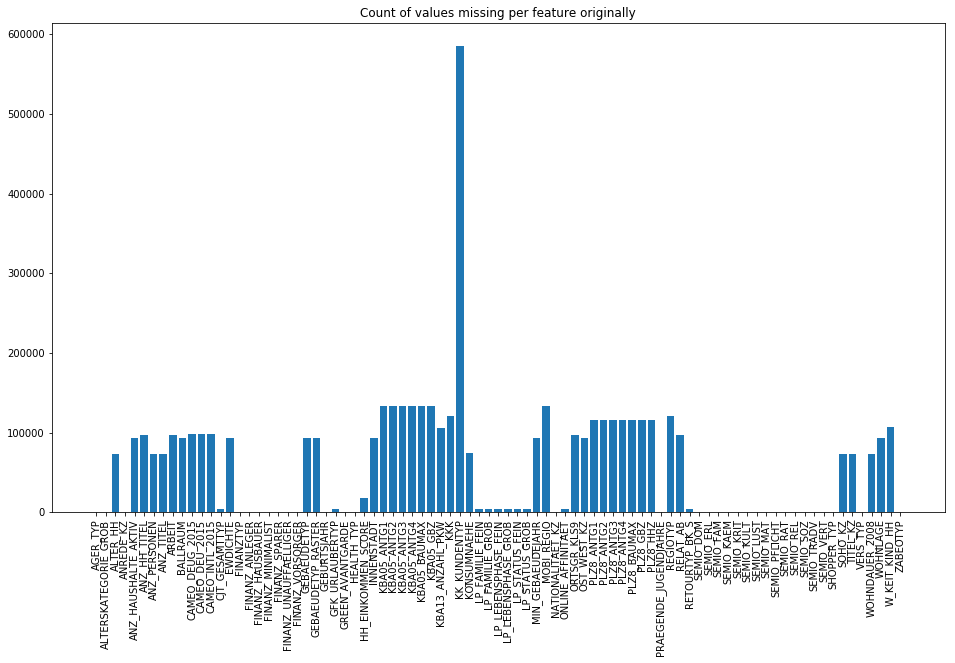

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#plot of how much data is missing originally
plt.figure(figsize=(16,9))
plt.xticks(rotation='vertical')
plt.title('Count of values missing per feature originally')
plt.bar(x=azdias_missing_original.index.values, height=azdias_missing_original.values)

<Container object of 85 artists>

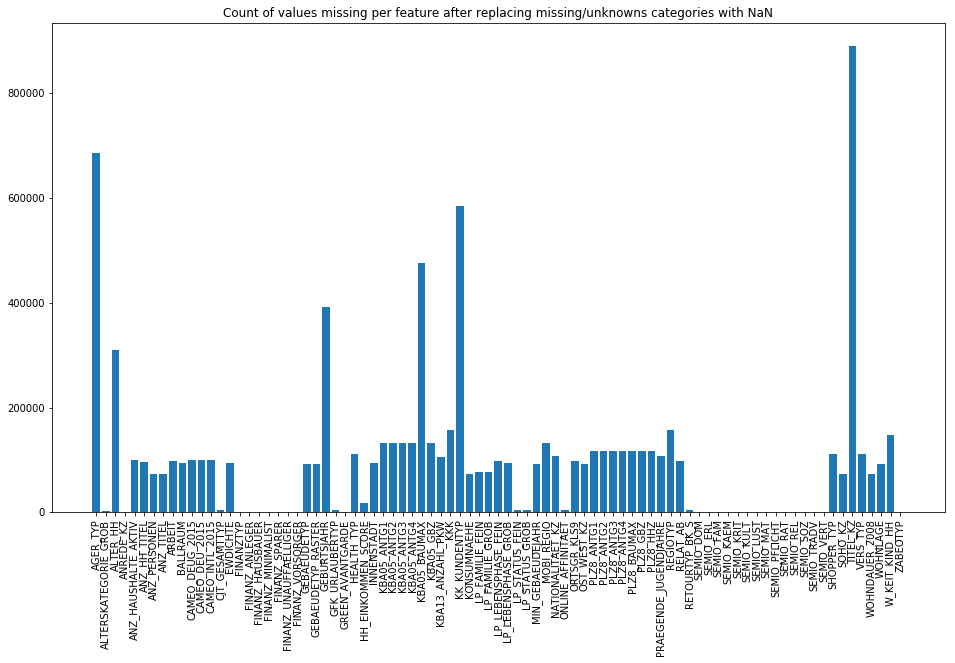

In [9]:
#plot of how much data is missing after replacing
# missing/unknown values with NaNs 
plt.figure(figsize=(16,9))
plt.xticks(rotation='vertical')
plt.title('Count of values missing per feature after replacing missing/unknowns categories with NaN')
plt.bar(x=azdias.columns.values, height=azdias.isna().sum().values)

In [10]:
# Investigate patterns in the amount of missing data in each column.

# Analyzing columns which have more than 5% missing data
nan_cols = azdias.columns[azdias.isna().sum() > len(azdias)*0.05]
print(nan_cols)

# remaining columns
rem_cols = list(set(azdias.columns) - set(nan_cols))

Index(['AGER_TYP', 'GEBURTSJAHR', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_KZ',
       'TITEL_KZ', 'VERS_TYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB'],
      dtype='object')


In [11]:
# For each column from the nan_cols seperate the data into two sets.
# First set has rows which have that feature missing but all the features in rem_cols are present.
# The second has rows in which both the rem_cols and the column of interest have valid data
# Treating the features in rem_cols as independent variables and the columns of interest as 
# Dependent variable, see which features in rem_cols can predict when the data in the column of 
# interest is missing

# The code below shows an example of this analysis carried out for the feature 'W_KEIT_KIND_HH'
col = 'W_KEIT_KIND_HH'

# rows in which the feature of interest, col, has NaNs but the remaining features, rem_cols,
# have valid values
df_missing = azdias[azdias[col].isna() & ~azdias[rem_cols].isna().any(axis=1)]

# rows in which neither the feature of interest, col, nor the remaining features, rem_cols,
# have NaNs
df_not_missing = azdias[azdias[col].notna() & ~azdias[rem_cols].isna().any(axis=1)]

# take equal number of both to have a fair representation
num_rows = min(df_missing.shape[0], df_not_missing.shape[0])

X = pd.concat([df_not_missing.sample(n=num_rows, random_state=42), df_missing.sample(n=num_rows, random_state=42)])

# replace NaNs with 1 and valid values with 0, since we are trying to predict NaNs
y = X[col].isna().astype(int)

# Only retain the target column and independent variables i.e. rem_cols
X = X.drop(columns=nan_cols)

# Use RandomForest classifier to predict missing values in the feature of interest
# based on other features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
fi = pd.Series(clf.feature_importances_, index=X_train.columns)
# List the top four features of importance
print(fi.sort_values(ascending=False).head(4))
    

0.87395921436
SEMIO_REL     0.099887
SEMIO_VERT    0.080742
SEMIO_ERL     0.067506
SEMIO_KULT    0.064005
dtype: float64


In [12]:
# Confirm the feature importance
# Categorize the missing and non-missing data by the features of importance to 
# look for patterns
print(df_missing['SEMIO_REL'].value_counts())
print(azdias['SEMIO_REL'].mean())
print(df_not_missing['SEMIO_REL'].value_counts())
# Below output shows the missing values are disprortionately higher for
# individuals with lowest religious affinity of 7.0

7.0    91049
4.0    13882
3.0     8697
1.0     5875
5.0     5082
2.0     4782
6.0     3645
Name: SEMIO_REL, dtype: int64
4.2406092316
4.0    185601
3.0    141146
7.0    115995
1.0     98397
5.0     69801
2.0     65721
6.0     55649
Name: SEMIO_REL, dtype: int64


In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

def get_interquartiles(df):
    '''
    Get the first, third and interquartile range 
    Input: Dataframe for which to get the quartiles
    '''
    first_q = np.percentile(df.values, 25.0)
    third_q = np.percentile(df.values, 75.0)
    
    return (first_q, third_q, third_q - first_q)

In [14]:
# Identifying outliers columns as being 
# 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile
_, third_quartile, iqr = get_interquartiles(azdias.isna().sum())
print(f'Inter quartile range: {iqr}')

missing_data_outlier_cols = azdias.columns[azdias.isna().sum() > (third_quartile + 1.5*iqr)]
print(missing_data_outlier_cols)

azdias = azdias.drop(columns=missing_data_outlier_cols)
print(azdias.shape)

Inter quartile range: 116515.0
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
(891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

53 columns had more than 5% of data missing.
To identify the outlier columns with missing data, I calculated the Inter quartile range for missing values and used third quartile + 1.5 times the Inter quartile range as a basis to identify the outlier columns. This analysis helped identify 6 columns that were dropped. These were - 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX'

To identify patterns in missing data, I used the Random Forest classifier. 
I marked the NaN's in the column for which I'm trying to identify the pattern of missing data as 1, the target, and non NaN's as 0. Then I used the least frequently missing features in the data to train the random forest classifier to predict when the column of interest has NaNs. This yielded some interesting insights which I further verified in the sections below.

Here are some patterns in the missing data:
* NATIONALITAET_KZ, SHOPPER_TYP, VERS_TYP, HEALTH_TYP are all missing data for almost the same entries. Most of these missing values are for people with lowest religious affinity on the personality typology(SEMIO_REL)

In [15]:
print('Total missing values for NATIONALITAET_KZ: ', azdias['NATIONALITAET_KZ'].isna().sum())
print('Missing values with SEMIO_REL = 7: ', ((azdias['NATIONALITAET_KZ'].isna()) & (azdias['SEMIO_REL'] == 7.0)).sum())

Total missing values for NATIONALITAET_KZ:  108315
Missing values with SEMIO_REL = 7:  101949


* SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, WOHNDAUER_2008 and KONSUMNAEHE are all missing data for the same entries. These entries also have same/very similar values for  all the Personality typology features (SEMIO_*), all the financial typology features (FINANZ_*), ZABEOTYP and HH_EINKOMMEN_SCORE. And in general, the building level features have missing data when the household income score is very high.

In [16]:
print('Total missing values for SOHO_KZ: ', azdias['SOHO_KZ'].isna().sum())
print('Missing values with SEMIO_REL = 7: ', ((azdias['SOHO_KZ'].isna()) & (azdias['SEMIO_REL'] == 7.0)).sum())
print('Missing values with HH_EINKOMMEN_SCORE = 2: ', ((azdias['SOHO_KZ'].isna()) & (azdias['HH_EINKOMMEN_SCORE'] == 2.0)).sum())

Total missing values for SOHO_KZ:  73499
Missing values with SEMIO_REL = 7:  73499
Missing values with HH_EINKOMMEN_SCORE = 2:  73499


* REGIOTYP, (neighborhood type) and KKK (purchasing power in region), appears to me missing for newer neighbourhoods (higher MIN_GEBAEUDEJAHR), perhaps because it's difficult to categorize them yet

In [17]:
missing_regiotyp = azdias['REGIOTYP'].isna()
print('Total missing values for REGIOTYP: ', missing_regiotyp.sum())
print('Mean value for MIN_GEBAEUDEJAHR: ', azdias.MIN_GEBAEUDEJAHR.mean())
print('Mean value for MIN_GEBAEUDEJAHR not missing REGIOTYP: ', azdias[~missing_regiotyp].MIN_GEBAEUDEJAHR.mean())
print('Mean value for MIN_GEBAEUDEJAHR missing REGIOTYP: ', azdias[missing_regiotyp].MIN_GEBAEUDEJAHR.mean())

Total missing values for REGIOTYP:  158064
Mean value for MIN_GEBAEUDEJAHR:  1993.277011
Mean value for MIN_GEBAEUDEJAHR not missing REGIOTYP:  1992.7786054
Mean value for MIN_GEBAEUDEJAHR missing REGIOTYP:  1998.90597079


* HEALTH_TYP data seems to be missing more often for people with low religious affinity, SEMIO_REL

In [18]:
print('Total missing values for HEALTH_TYP: ', azdias['HEALTH_TYP'].isna().sum())
print('Missing values with SEMIO_REL = 7: ', ((azdias['HEALTH_TYP'].isna()) & (azdias['SEMIO_REL'] == 7.0)).sum())

Total missing values for HEALTH_TYP:  111196
Missing values with SEMIO_REL = 7:  103730


* NATIONALITAET_KZ data seems to be missing more commonly for people with low religious affinity, SEMIO_REL

In [19]:
print('Total missing values for NATIONALITAET_KZ: ', azdias['NATIONALITAET_KZ'].isna().sum())
print('Missing values with SEMIO_REL = 7: ', ((azdias['NATIONALITAET_KZ'].isna()) & (azdias['SEMIO_REL'] == 7.0)).sum())

Total missing values for NATIONALITAET_KZ:  108315
Missing values with SEMIO_REL = 7:  101949


* data missing for PRAEGENDE_JUGENDJAHRE has a high overlap with data missing for NATIONALITAET_KZ. Also data is more often missing for PRAEGENDE_JUGENDJAHRE for individuals who rank lower on the investor scale (FINANZ_ANLEGER) and high affinity on the dreamful scale (SEMIO_VERT)

In [20]:
print('Total missing values for PRAEGENDE_JUGENDJAHRE: ', azdias['PRAEGENDE_JUGENDJAHRE'].isna().sum())
print('Total missing values for NATIONALITAET_KZ: ', azdias['NATIONALITAET_KZ'].isna().sum())
print('Missing common data: ', (azdias['PRAEGENDE_JUGENDJAHRE'].isna() & azdias['NATIONALITAET_KZ'].isna()).sum())

print('Missing values with FINANZ_ANLEGER = 5: ', ((azdias['PRAEGENDE_JUGENDJAHRE'].isna()) & (azdias['FINANZ_ANLEGER'] == 5.0)).sum())
print('Missing values with SEMIO_VERT = 1: ', ((azdias['PRAEGENDE_JUGENDJAHRE'].isna()) & (azdias['SEMIO_VERT'] == 1.0)).sum())

Total missing values for PRAEGENDE_JUGENDJAHRE:  108164
Total missing values for NATIONALITAET_KZ:  108315
Missing common data:  92690
Missing values with FINANZ_ANLEGER = 5:  91702
Missing values with SEMIO_VERT = 1:  79671


* SHOPPER_TYP and VERS_TYP features have more missing data for people with low religios affinity, SEMIO_REL

In [21]:
print('Total missing values for SHOPPER_TYP: ', azdias['SHOPPER_TYP'].isna().sum())
print('Missing values with SEMIO_REL = 7: ', ((azdias['SHOPPER_TYP'].isna()) & (azdias['SEMIO_REL'] == 7.0)).sum())

Total missing values for SHOPPER_TYP:  111196
Missing values with SEMIO_REL = 7:  103730


* ANZ_PERSONEN, the number of adults in the household seems to be missing data when the individuals have a higher affinity on dreamful nature, SEMIO_VERT.

In [22]:
print('Total missing values for ANZ_PERSONEN: ',azdias['ANZ_PERSONEN'].isna().sum())
print('Missing values with SEMIO_VERT = 1: ',((azdias['ANZ_PERSONEN'].isna()) & (azdias['SEMIO_VERT'] == 1.0)).sum())

Total missing values for ANZ_PERSONEN:  73499
Missing values with SEMIO_VERT = 1:  73499


* ANZ_HAUSHALTE_AKTIV and ANZ_HH_TITEL have more missing data for househols with very high income score (HH_EINKOMMEN_SCORE) and with the highest affinity on dreamful personal typology (SEMIO_VERT) and low on religios affinity

In [23]:
print('Total missing values for ANZ_HAUSHALTE_AKTIV: ',azdias['ANZ_HAUSHALTE_AKTIV'].isna().sum())
print('Missing values with SEMIO_REL = 7: ',((azdias['ANZ_HAUSHALTE_AKTIV'].isna()) & (azdias['SEMIO_REL'] == 7.0)).sum())
print('Missing values with SEMIO_VERT = 1: ',((azdias['ANZ_HAUSHALTE_AKTIV'].isna()) & (azdias['SEMIO_VERT'] == 1.0)).sum())
print('Missing values with HH_EINKOMMEN_SCORE = 2: ',((azdias['ANZ_HAUSHALTE_AKTIV'].isna()) & (azdias['HH_EINKOMMEN_SCORE'] == 2.0)).sum())

Total missing values for ANZ_HAUSHALTE_AKTIV:  99611
Missing values with SEMIO_REL = 7:  76339
Missing values with SEMIO_VERT = 1:  76234
Missing values with HH_EINKOMMEN_SCORE = 2:  75726


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?
azdias_row_nan_counts = azdias.isna().sum(axis=1)

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# calculate the inter-quartile range
# split the dataset based on 1.5* iqr + third quartile

_, missing_rows_third_quartile, missing_rows_iqr = get_interquartiles(azdias.isna().sum(axis=1))

print('Inter quartile range:', missing_rows_iqr)
azdias_wo_missing_cols = azdias.loc[azdias_row_nan_counts <= (missing_rows_third_quartile + 1.5 * missing_rows_iqr)]
azdias_w_missing_cols = azdias.loc[azdias_row_nan_counts > (missing_rows_third_quartile + 1.5 * missing_rows_iqr)]
print('No. of Rows to be retained:', azdias_wo_missing_cols.shape[0])
print('No. of Rows to be ignored:', azdias_w_missing_cols.shape[0])

Inter quartile range: 3.0
No. of Rows to be retained: 747109
No. of Rows to be ignored: 144112


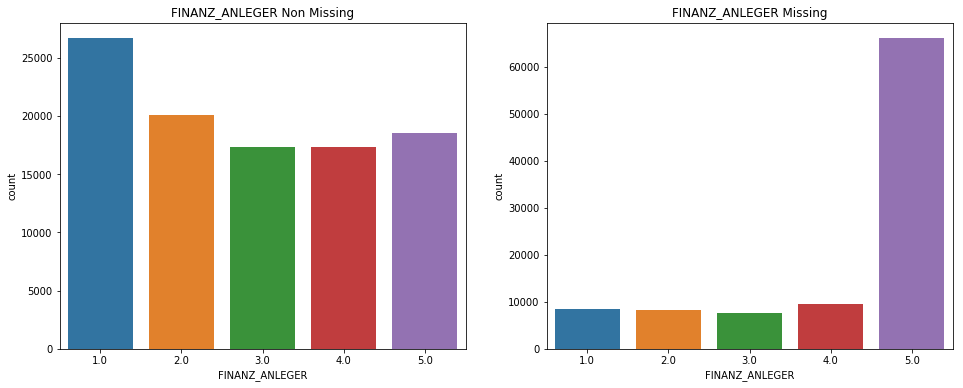

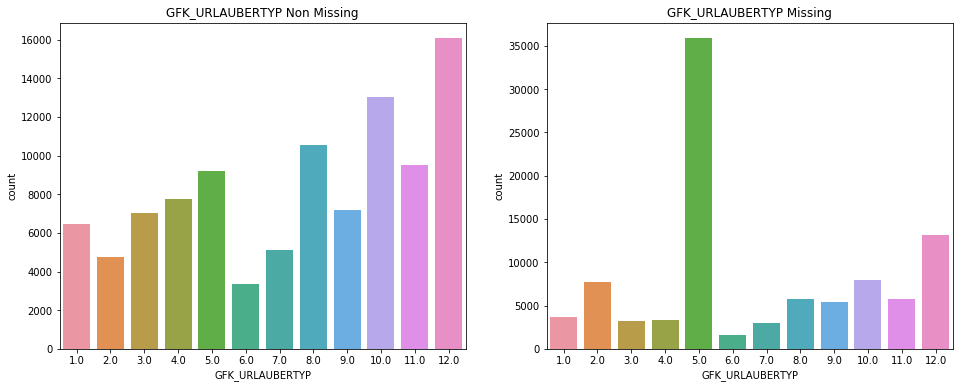

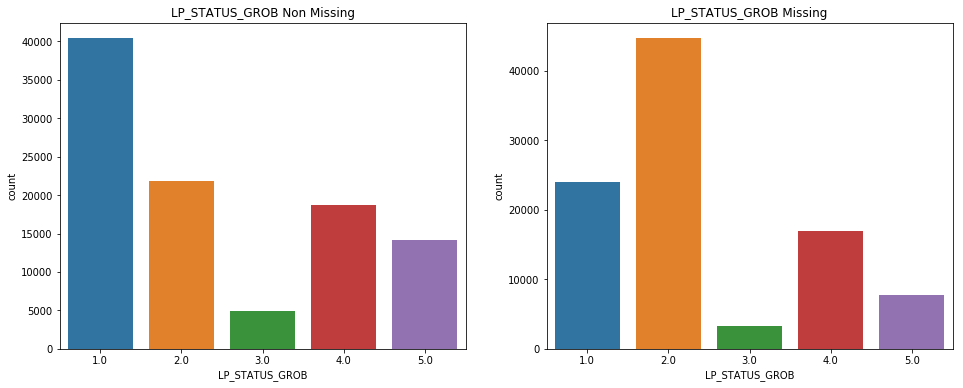

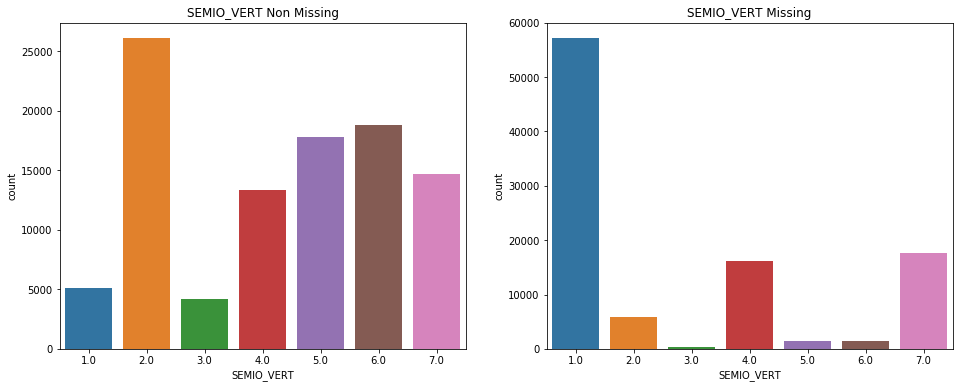

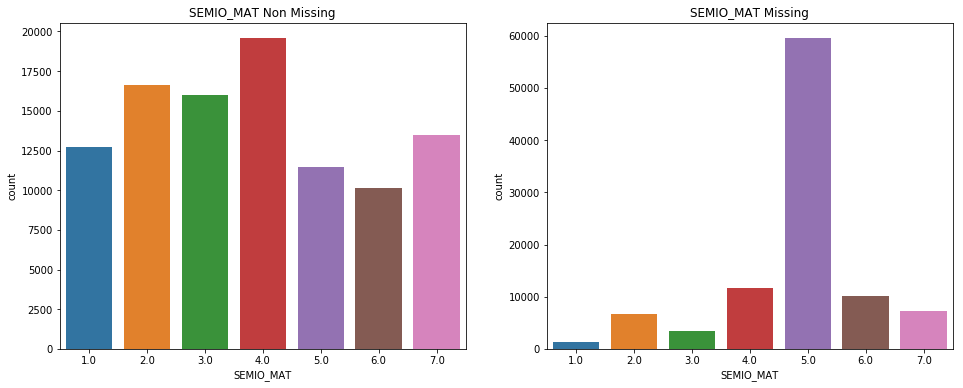

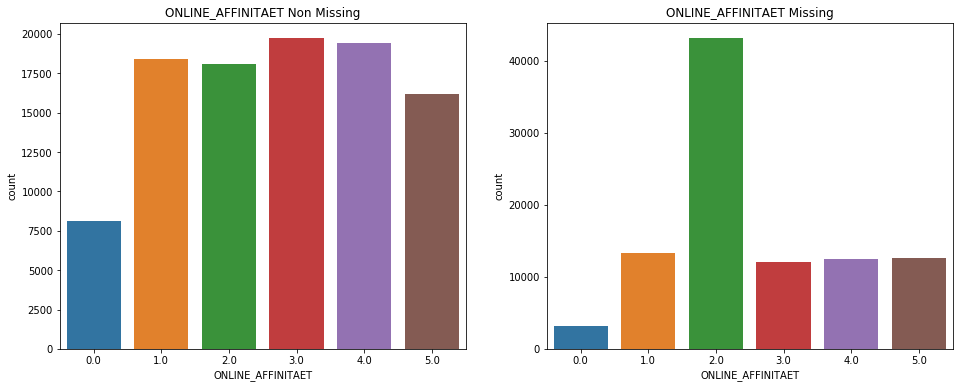

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# using these six columns for comparision: 
# 'FINANZ_ANLEGER', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB', 'SEMIO_VERT', 'SEMIO_MAT' and 'ONLINE_AFFINITAET'

def compare_distribution(col):
    '''
    This function plots the value counts for a feature in the missing 
    and non-missing datasets side-by-side
    INPUT: The column name in the dataset to plot
    OUTPUT: None
    '''
    sample_size = 100000
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.title(col +' Non Missing')
    sns.countplot(azdias_wo_missing_cols[col].sample(sample_size))

    plt.subplot(1,2,2)
    plt.title(col +' Missing')
    sns.countplot(azdias_w_missing_cols[col].sample(sample_size))

cols = ['FINANZ_ANLEGER', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB', 'SEMIO_VERT', 'SEMIO_MAT', 'ONLINE_AFFINITAET']
for col in cols:
    compare_distribution(col)

In [27]:
def drop_rows_with_missing_data(df, third_quartile=None, iqr=None):
    '''
    This function drops the rows missing more values than the iqr
    and the returns the resulting data frame
    INPUT: df - the dataframe to drop the rows from
           third_quartile - the third quartile for the data, calculated if not passed
           iqr - the interquartile range, calculated if not passed 
    OUTPUT: dataframe without the rows containing more missing values than iqr
    '''
    if not iqr:
        _, third_quartile, iqr = get_interquartiles(df.isna().sum(axis=1))
    return df.loc[df.isna().sum(axis=1).values <= (third_quartile + 1.5 * iqr)]

In [28]:
# saving a copy of the dataset with all rows, 
# and update the azdias dataframe to be the one with no (very few) missing columns
azdias_all_rows = azdias.copy()
azdias = drop_rows_with_missing_data(azdias)

In [29]:
print(azdias.shape)
azdias_rows_dropped = azdias_rows - azdias.shape[0]

(747109, 79)


#### Discussion 1.1.3: Assess Missing Data in Each Row

To dentify rows with missing values, I used the same appraoch of 1.5 Inter quartile range above the third quartile as used above for columns. This appraoch yielded a cut-off value of 7.5 missing values per row.
The dataset was split into two groups using this threshold value of 4.5 missing values per row. 144112 rows were dropped from the dataset based on this calculation, leaving 747109 rows in the dataset.

The features that were used for comparing the distributions in the set with less missing values with the set with more missing values were 'FINANZ_ANLEGER', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB', 'SEMIO_VERT', 'SEMIO_MAT' and 'ONLINE_AFFINITAET'.
Except for the feature 'LP_STATUS_GROB', which has slightly similar distribution between the groups, the remaining 5 features
had quite different distributions

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def re_encode_categorical_data(df):
    '''
    This function re-encodes the categorical variables in the dataframe passed
    and returns the resulting dataframe
    INPUT: The dataframe whose categorical features need to be re-encoded
    OUTPUT: Dataframe with categorical features re-encoded
    '''

    # CAMEO_DEU_2015 adds over forty features if one-hot encoded and besides the dataset has the 
    # Wealth / Life Stage Typology at a less detailed level in the feature CAMEO_DEUG_2015, so
    # I'll drop the CAMEO_DEU_2015 from the dataset
    # LP_FAMILIE_* and LP_STATUS_* have a fine and a broad scale, for these features since the 
    # fine scale doesnt add too many categories compared to the broad, I'll keep the fine scale and
    # discard the broad scale

    df.drop(columns=['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEU_2015'], inplace=True)

    # For the feature GEBAEUDETYP, there are very few entries in category 5 (1) and category 6 (628).
    # Category 5 can be discarded and category 6 can be combined with category 4
    df.drop(df[df.GEBAEUDETYP == 5].index, inplace=True)
    df.loc[df.GEBAEUDETYP == 6, 'GEBAEUDETYP'] = 4

    # Identify the categorical columns
    categorical_cols = feat_info[feat_info.type == 'categorical'].attribute.values

    # Find the remaining categorical columns which need to be encoded
    encode_cols = []
    for col in categorical_cols:
        if col not in df.columns:
            # we dropped some columns already
            continue
        if (len(df[col].dropna().unique()) != 2) | (df[col].dropna().unique().dtype == 'object'):
            encode_cols.append(col)

    return pd.get_dummies(df, columns=encode_cols, drop_first=True)

In [32]:
# Dummy encode the categorical variable(s) to be kept in the analysis.
azdias = re_encode_categorical_data(azdias)
print(azdias.shape)

(747108, 128)


#### Discussion 1.2.1: Re-Encode Categorical Features

CAMEO_DEU_2015 adds over forty features if one-hot encoded and besides the dataset has the Wealth / Life Stage Typology at a less detailed level in the feature CAMEO_DEUG_2015, so I dropped CAMEO_DEU_2015 from the dataset.

Of the remaining categorical features, these are the ones that have been encoded using the one-hot encoder - 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015'.

For the feature GEBAEUDETYP, there are very few entries in category 5 (1) and category 6 (628). Category 5 can be discarded and category 6 can be combined with category 4

This results in 49 new features being created.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
def engineer_praegende_jugendjahre(df):
    '''
    This function converts PRAEGENDE_JUGENDJAHRE into two new features
    YOUTH_DECADE and YOUTH_MOVEMENT and drops the original feature
    INPUT: The dataframe containing the feature PRAEGENDE_JUGENDJAHRE
    OUTPUT: The dataframe with the replaced features
    '''
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # create a YOUTH_DECADE feature with values 1-6 corresponding to 40s-90s
    decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    # create a YOUTH_MOVEMENT feature with values 0/1 corresponding to Mainstream/Avantgarde
    movement_map ={1:0, 3:0, 5:0, 8:0, 10:0, 12:0, 14:0, 2:1, 4:1, 6:1, 7:1, 9:1, 11:1, 13:1, 15:1}

    df['YOUTH_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    df['YOUTH_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)

    # drop the original column
    df.drop(columns='PRAEGENDE_JUGENDJAHRE', inplace=True)
    return df

In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables
def engineer_cameo_intl_2015(df):
    '''
    This function converts CAMEO_INTL_2015 into two new features
    CAMEO_WEALTH and CAMEO_LIFESTAGE and drops the original feature
    INPUT: The dataframe containing the feature CAMEO_INTL_2015
    OUTPUT: The dataframe with the replaced features
    '''
    # creating two new featres CAMEO_WEALTH and CAMEO_LIFESTAGE from CAMEO_INTL_2015
    def cameo_intl_2015_to_wealth(x):
        if not pd.isnull(x):
            return int(x)//10
        return x

    # create a CAMEO_WEALTH feature with values 1-5 
    df['CAMEO_WEALTH'] = df['CAMEO_INTL_2015'].map(cameo_intl_2015_to_wealth)

    def cameo_intl_2015_to_lifestage(x):
        if not pd.isnull(x):
            return int(x)%10
        return x

    # create a CAMEO_LIFESTAGE feature with values 1-5
    df['CAMEO_LIFESTAGE'] = df['CAMEO_INTL_2015'].map(cameo_intl_2015_to_lifestage)

    # drop the original column
    df.drop(columns='CAMEO_INTL_2015', inplace=True)
    
    return df

In [35]:
def engineer_wohnlage(df):
    # WOHNLAGE feature is a mized feature as it includes the neighborhood quality
    # along with a 'rural' flag
    # As the number of entries with the rural flag is very low, combining these 
    # with the rural neighborhood entries
    # This in essence convers it from a mixed feature to numerical feature 
    df.loc[azdias.WOHNLAGE == 8.0, 'WOHNLAGE'] = 7.0
    return df

In [36]:
def engineer_lp_lebensphase_fein(df):
    '''
    This function converts LP_LEBENSPHASE_FEIN into three new features
    LP_LEBENSPHASE_AGE, LP_LEBENSPHASE_INCOME and LP_LEBENSPHASE_STATUS and the original feature.
    LP_LEBENSPHASE_STATUS is further converted into a categorical feature and dummy encoded
    into 5 categories
    INPUT: The dataframe containing the feature LP_LEBENSPHASE_FEIN
    OUTPUT: The dataframe with the replaced features
    '''    
    # Split LP_LEBENSPHASE_FEIN into three features 
    # LP_LEBENSPHASE_AGE with range 1-5 with 1 being younger age and 5 retirement age
    # LP_LEBENSPHASE_INCOME with range 1-5 with 1 being low income and 5 top earners
    # LP_LEBENSPHASE_STATUS which will be converted to a categorical feature and dummy encoded
    # The categories for LP_LEBENSPHASE_STATUS will be 1 - single, 2 - couple, 
    # 3 - single_parent, 4 - family, 5 - multiperson_hh

    age_map = { 1:1,3:1,14:1,18:1,29:1,30:1,33:1,34:1,35:1,
                2:2,4:2,10:2,39:2,17:2,21:2,22:2,23:2,24:2,25:2,26:2,27:2,28:2,
                5:3,7:3,9:3,11:3,37:3,                                                                                      
                13:4,15:4,16:4,19:4,20:4,31:4,32:4,36:4,
                6:5,8:5,12:5,38:5,40:5 }

    df['LP_LEBENSPHASE_AGE'] = df['LP_LEBENSPHASE_FEIN'].map(age_map)

    income_map =  { 1:1,2:1,5:1,6:1,15:1,21:1,24:1,29:1,31:1,
                    3:2,4:2,7:2,8:2,14:2,16:2,22:2,25:2,30:2,32:2,
                    10:3,11:3,12:3,18:3,19:3,23:3,27:3,34:3,37:3,38:3,
                    9:4,17:4,26:4,33:4,36:4,
                    13:5,20:5,28:5,35:5,39:5,40:5 }

    df['LP_LEBENSPHASE_INCOME'] = df['LP_LEBENSPHASE_FEIN'].map(income_map)

    def lp_lebenphase_status(x):
        if pd.isnull(x):
            return x
        if 1 <= x <= 13:
            return 1
        elif 14 <= x <= 20:
            return 2
        elif 21 <= x <= 23:
            return 3
        elif 24 <= x <= 28:
            return 4
        else:
            return 5
    
    # create a LP_LEBENSPHASE_STATUS feature with values 1-5 
    df['LP_LEBENSPHASE_STATUS'] = df['LP_LEBENSPHASE_FEIN'].map(lp_lebenphase_status)

    # dummy encode this feature to convert it into categorical
    df = pd.get_dummies(df, columns=['LP_LEBENSPHASE_STATUS'], drop_first=True)

    # drop the original column
    df.drop(columns='LP_LEBENSPHASE_FEIN', inplace=True)

    # Also drop LP_LEBENSPHASE_GROB since the information in this feature is now be redundant
    df.drop(columns='LP_LEBENSPHASE_GROB', inplace=True)
    
    return df

In [37]:
def engineer_mixed_features(df):
    '''
    This function combines all the mixed feature engineering functions
    INPUT: Dataframe with the mixed features
    OUTPUT: Dataframe with the mixed features engineered into different features
    '''
    df = engineer_praegende_jugendjahre(df)
    df = engineer_cameo_intl_2015(df)
    df = engineer_wohnlage(df)
    df = engineer_lp_lebensphase_fein(df)
    return df

In [38]:
azdias = engineer_mixed_features(azdias)
azdias.shape

(747108, 134)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I've created two new features from PRAEGENDE_JUGENDJAHRE named YOUTH_DECADE and YOUTH_MOVEMENT, and two new features from CAMEO_INTL_2015 named CAMEO_WEALTH and CAMEO_LIFESTAGE. 
For the feature WOHNLAGE, there is only one category which makes this a mixed feature. 'new building in rural neighborhood'. Since there are very few entries in this category, am combining this category with the broader 'rural neighborhood' category.

I engineered three features from LP_LEBENSPHASE_FEIN - LP_LEBENSPHASE_AGE, LP_LEBENSPHASE_INCOME and LP_LEBENSPHASE_STATUS
Age and Income are ordinal so I left them as is. For status, I converted it into a categorical feature and dummy encoded it. The categories for status are single, couple, single_parent, family and multiperson_household
Since these features capture all the relevant information from LP_LEBENSPHASE_FEIN, I've dropped LP_LEBENSPHASE_GROB feature.

There are total of 134 features after this step

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # convert missing value codes into NaNs, ...
    df = replace_missing_unknown(df)
    
    # remove selected columns and rows, ...
    
    # remove the same missing data outlier columns as the demographic data
    df = df.drop(columns=missing_data_outlier_cols)

    # drop the rows with missing data above 1.5*iqr
    # the iqr to be used is from the demographic data, which is the
    # same value used for the customer data too
    df = drop_rows_with_missing_data(df, missing_rows_third_quartile, missing_rows_iqr)
    
    # select, re-encode, and engineer column values.
    df = re_encode_categorical_data(df)
    
    df = engineer_mixed_features(df)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# Identify columns with missing data and 
# impute the NaNs with 'most_frequent'
imputer = preprocessing.Imputer(strategy='most_frequent')
azdias = pd.DataFrame(imputer.fit_transform(azdias), columns=azdias.columns)

In [41]:
# verify there are no columns with NaNs
azdias.columns[azdias.isna().sum() != 0]

Index([], dtype='object')

In [42]:
# Apply feature scaling to the general population demographics data.
scaler = preprocessing.StandardScaler()
azdias = pd.DataFrame(scaler.fit_transform(azdias), columns=azdias.columns)

In [43]:
display(azdias.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,YOUTH_DECADE,YOUTH_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFESTAGE,LP_LEBENSPHASE_AGE,LP_LEBENSPHASE_INCOME,LP_LEBENSPHASE_STATUS_2.0,LP_LEBENSPHASE_STATUS_3.0,LP_LEBENSPHASE_STATUS_4.0,LP_LEBENSPHASE_STATUS_5.0
0,-1.754917,0.962858,-1.503660,1.559940,-1.049534,1.490707,1.013168,1.331158,-0.536372,1.013073,...,1.123586,-0.536372,1.164586,-1.249678,-0.511384,-0.918378,-0.373521,5.292710,-0.252689,-0.560036
1,0.198237,0.962858,-1.503660,0.884836,-1.773084,-0.555632,0.291141,1.331158,1.864376,1.013073,...,1.123586,1.864376,-0.880211,0.758859,-1.210798,-0.180954,-0.373521,-0.188939,-0.252689,-0.560036
2,1.174815,0.962858,0.685684,-0.465374,1.121117,-0.555632,-1.152911,-0.831846,-0.536372,-0.309432,...,-0.241508,-0.536372,-1.561810,-0.580166,-1.210798,-0.918378,-0.373521,-0.188939,-0.252689,-0.560036
3,0.198237,-1.038575,0.685684,0.209731,0.397567,-1.237745,0.291141,-0.831846,-0.536372,1.013073,...,-0.241508,-0.536372,0.482987,0.089347,0.887444,-0.180954,-0.373521,-0.188939,-0.252689,1.785599
4,-1.754917,0.962858,-0.044097,-1.140478,1.121117,-0.555632,-0.430885,1.331158,-0.536372,1.013073,...,-1.606602,-0.536372,1.164586,0.758859,1.586858,-0.180954,-0.373521,-0.188939,-0.252689,-0.560036


### Discussion 2.1: Apply Feature Scaling

For imputation I used a Simple imputer and replaced the NaNs with 'most_frequent'. I went with this approach since some of the distributions are skewed. 
For scaling, I used the standard scaler with 0 mean and 1 standard deviation.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.
pca = PCA(random_state=42)
pca.fit(azdias)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

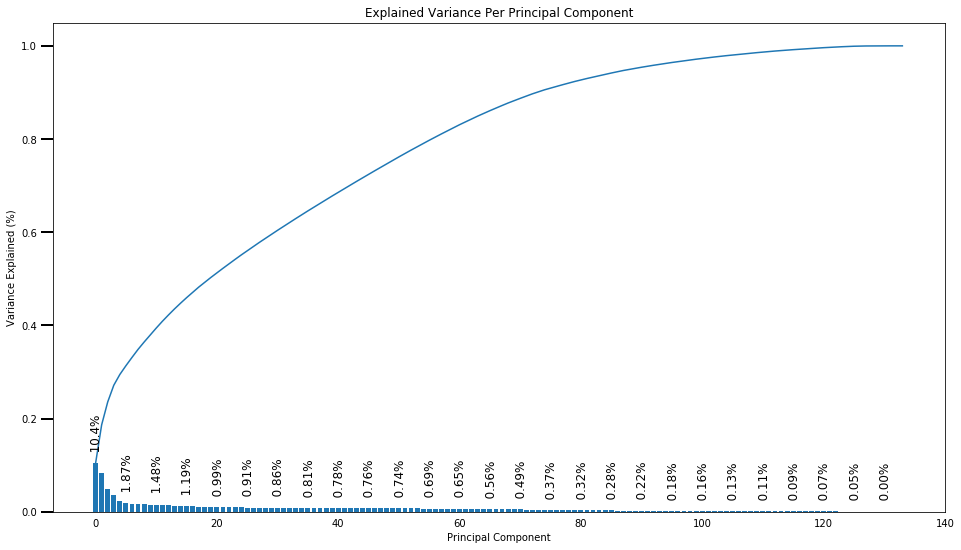

In [45]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    INPUT: pca - the result of instantiation of PCA in scikit learn
    OUTPUT:None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 9))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(0,num_components,5):
        ax.annotate(r"   %s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12, rotation=90)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [46]:
# Investigate the variance accounted for by each principal component.
# Identify the number of components requied to account for 90% variance in the data
cumsum = np.cumsum(pca.explained_variance_ratio_)
n_comps = np.argmax(cumsum >= 0.9) + 1
print(n_comps)

74


In [47]:
# Re-apply PCA to the data while selecting for number of components to retain.

# re fit PCA with the chosen number of components
pca = PCA(n_components = n_comps, random_state=42)
azdias_pca =  pca.fit_transform(azdias)

### Discussion 2.2: Perform Dimensionality Reduction

The first 5 components account for about 30% of the variance in the data. The explained variance tapers off gradually and at about 75 components we see a 'bend in the elbow' showing that the explained variance is not increasing much from this point.
I'm choosing 74 components which explain 90% of variance in the data

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [48]:
def sorted_feature_weights(weights, indices):
    '''
    Associate the weights with the indices and return a sorted series in 
    descending order based on the weights
    INPUT: 
            weights - the array of weights to sort
            indices - the array of corresponding indices
    OUTPUT:
            A Series with the weights sorted in descending order
    '''
    pc_weights = pd.Series(weights, index=indices)
    pc_weights.sort_values(ascending=False, inplace=True)
    return pc_weights

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc_weights = sorted_feature_weights(pca.components_[0], azdias.columns)
print(pc_weights.head(6))
print(pc_weights.tail(6))

PLZ8_ANTG3            0.185610
PLZ8_ANTG4            0.180729
HH_EINKOMMEN_SCORE    0.179815
CAMEO_WEALTH          0.177584
PLZ8_BAUMAX           0.177422
ORTSGR_KLS9           0.158114
dtype: float64
KBA05_GBZ               -0.180584
PLZ8_ANTG1              -0.186746
KBA05_ANTG1             -0.187525
LP_LEBENSPHASE_INCOME   -0.190775
MOBI_REGIO              -0.198887
FINANZ_MINIMALIST       -0.205895
dtype: float64


In [50]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc_weights = sorted_feature_weights(pca.components_[1], azdias.columns)
print(pc_weights.head(6))
print(pc_weights.tail(6))

ALTERSKATEGORIE_GROB    0.212734
LP_LEBENSPHASE_AGE      0.207470
FINANZ_VORSORGER        0.203232
ZABEOTYP_3.0            0.193895
SEMIO_ERL               0.167947
RETOURTYP_BK_S          0.154831
dtype: float64
SEMIO_TRADV             -0.193040
FINANZ_ANLEGER          -0.193838
SEMIO_REL               -0.197751
FINANZ_UNAUFFAELLIGER   -0.201886
FINANZ_SPARER           -0.203485
YOUTH_DECADE            -0.215730
dtype: float64


In [51]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc_weights = sorted_feature_weights(pca.components_[2], azdias.columns)
print(pc_weights.head(6))
print(pc_weights.tail(6))

SEMIO_VERT           0.332418
SEMIO_FAM            0.267210
SEMIO_SOZ            0.264391
SEMIO_KULT           0.255759
FINANZTYP_5.0        0.139709
FINANZ_MINIMALIST    0.137358
dtype: float64
SEMIO_RAT    -0.160447
SEMIO_ERL    -0.207671
SEMIO_KRIT   -0.268208
SEMIO_DOM    -0.290500
SEMIO_KAEM   -0.325602
ANREDE_KZ    -0.355761
dtype: float64


### Discussion 2.3: Interpret Principal Components

Principal Component 1: This component has the positive weights for PLZ8_ANTG3, PLZ8_ANTG4, HH_EINKOMMEN_SCORE, CAMEO_WEALTH and PLZ8_BAUMAX in descending order of importance and the negative weights for FINANZ_MINIMALIST, MOBI_REGIO, LP_LEBENSPHASE_INCOME, KBA05_ANTG1 and PLZ8_ANTG1 in descending order of importance. This compoenent represents individuals in densely populated neighborhoods with high movement, like downtowns. They are lower income and low spending individuals.

The correlations show that while lower income, living in areas with 6+ family homes, movement in the region are positively correlated, they have a negavtive correlation with savings and number of 1-2 family homes in the neighborhood.

Principal Component 2: This component has positive weights for ALTERSKATEGORIE_GROB, LP_LEBENSPHASE_AGE, FINANZ_VORSORGER, ZABEOTYP_3 and SEMIO_ERL in descending order of importance and negtive weights for YOUTH_DECADE, FINANZ_SPARER, FINANZ_UNAUFFAELLIGER, SEMIO_REL and FINANZ_ANLEGER in descending order of importance. This component represents older individuals, more religios, traditional and with higher affinity for savings.

So while age, religiousness, savings and investing are positively correlated, they are negatively correlated to event-orientedness, green/smart energy

Principal component 3: This component has positive weights for SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT and FINANZTYP_5.0 in decreasing order of importance and negative weights for ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT and SEMIO_ERL in decreasing order of importance. This component represents not very dreamful, socially or family minded men, dominant and aggresive, somewhat into investing and spending.

The corerlations show that while women are mor dreamful, social, family and culture minded, men are more dominant, combative, event-oriented and investment savvy.

In summary the main components appear to be centered around Income, Age and Sex

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [52]:
# Over a number of different cluster counts...
scores = []
for n in range(2,20):    
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    scores.append(abs(kmeans.score(azdias_pca)))
    print(f'Score for {n} clusters: {scores[-1]}')

Score for 2 clusters: 82422289.4885744
Score for 3 clusters: 78130638.93865353
Score for 4 clusters: 75444231.49825111
Score for 5 clusters: 73676800.6977148
Score for 6 clusters: 72282522.96213305
Score for 7 clusters: 71052749.26437509
Score for 8 clusters: 70114600.2972295
Score for 9 clusters: 69156895.58066474
Score for 10 clusters: 68489135.42980593
Score for 11 clusters: 67981083.82964766
Score for 12 clusters: 67255280.10029382
Score for 13 clusters: 66512668.093167424
Score for 14 clusters: 65679797.278873615
Score for 15 clusters: 65801931.98351685
Score for 16 clusters: 64854008.36195449
Score for 17 clusters: 63974816.63217103
Score for 18 clusters: 64089996.06727843
Score for 19 clusters: 62931989.24298539


Text(0,0.5,'Score')

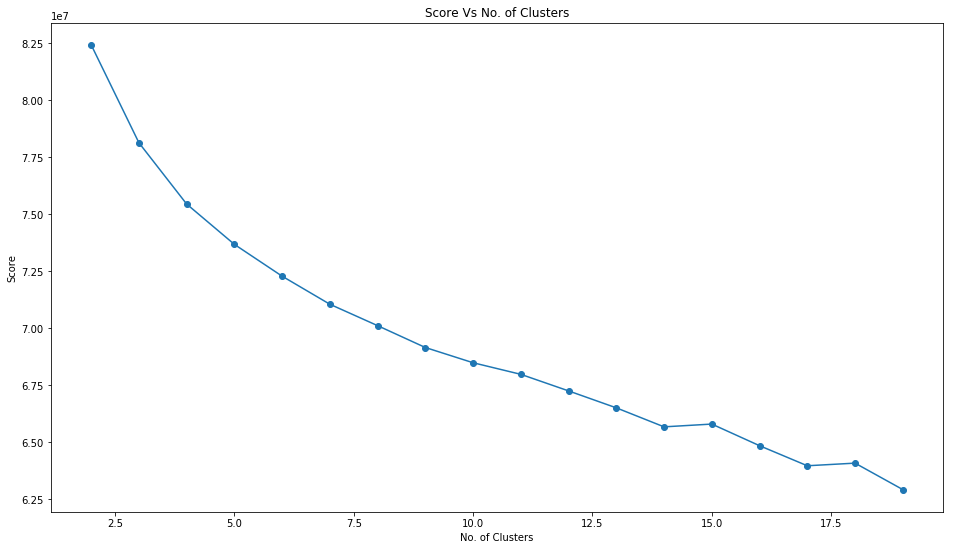

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
clusters = list(range(2,20))
plt.figure(figsize=(16, 9))
plt.plot(clusters, scores, marker='o')
plt.title('Score Vs No. of Clusters')
plt.xlabel('No. of Clusters')
plt.ylabel('Score')


In [54]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=9, random_state=42)
azdias_pred = kmeans.fit_predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

Applied Kmeans clustering and plotted the score by varying the number of clusters from 2 to 19.
The plot shows the scores reducing faster in the beginning for small number of clusters. After that the descent is gradual and there is no visible 'elbow'. However the reduction in score is small from about 9 clusters so I'm choosing a value of 9 for the number of clusters. I think this will give me decent number of categories to map the population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [55]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers_rows = customers.shape[0]

<Container object of 85 artists>

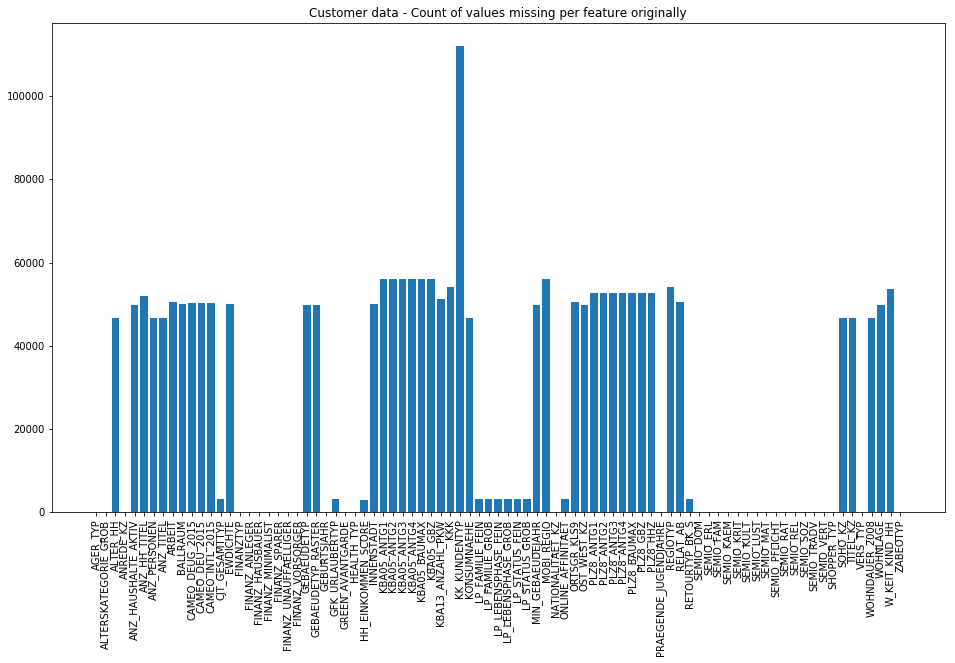

In [56]:
#plot the missing data
plt.figure(figsize=(16,9))
plt.xticks(rotation='vertical')
plt.title('Customer data - Count of values missing per feature originally')
plt.bar(x=customers.isna().sum().index.values, height=customers.isna().sum().values)

In [57]:
# clean the data
customers = clean_data(customers)

customers_rows_dropped = customers_rows - customers.shape[0]

In [58]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# apply imputation from general demographics to customer demographics
customers = pd.DataFrame(imputer.transform(customers), columns=customers.columns)

#verify there are no NaNs anymore
print(customers.columns[customers.isna().sum() != 0])

# apply standard scaler from general demographics to customer demographics
customers = pd.DataFrame(scaler.transform(customers), columns=customers.columns)

# apply pca from general demographics to customer demographics
customers_pca =  pca.transform(customers)

# predict the clusters for the customer demographics using the general demographics model
customers_pred = kmeans.predict(customers_pca)


Index([], dtype='object')


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

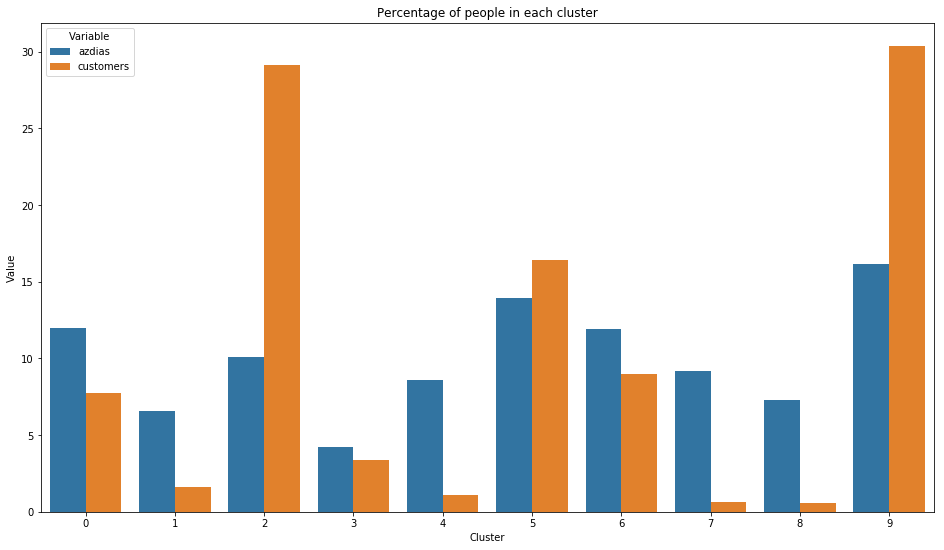

In [59]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cluster_idx, azdias_cluster_counts = np.unique(azdias_pred, return_counts=True)
_, customers_cluster_counts = np.unique(customers_pred, return_counts=True)

pred_map = {'cluster': cluster_idx, 
            'azdias': azdias_cluster_counts, 
            'customers': customers_cluster_counts}
cluster_preds = pd.DataFrame(pred_map)

# Add row for dropped missing data as another cluster
cluster_preds.loc[len(cluster_preds)] = [len(cluster_preds), azdias_rows_dropped, customers_rows_dropped]

# Convert the numbers in each cluster to a proportion of the corresponding dataset 
cluster_preds['azdias'] = (cluster_preds['azdias']/azdias_rows)*100
cluster_preds['customers'] = (cluster_preds['customers']/customers_rows)*100

plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
ax.set_title('Percentage of people in each cluster')

df = cluster_preds.melt(id_vars='cluster').rename(columns=str.title)
sns.barplot(x='Cluster', y='Value', hue='Variable', data=df, ax=ax)


In [60]:
display(cluster_preds)

,cluster,azdias,customers
0,0,11.977837,7.727026
1,1,6.566273,1.647256
2,2,10.119937,29.131968
3,3,4.243168,3.402521
4,4,8.587096,1.074343
5,5,13.959164,16.414647
6,6,11.926671,8.983992
7,7,9.178980,0.671530
8,8,7.270587,0.566130
9,9,16.170176,30.380586


In [61]:
# apply inverse transforms to the cluster centers to get their actual values
x = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_))
cluster_centers = pd.DataFrame(x, columns=azdias.columns)

display(cluster_centers)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,YOUTH_DECADE,YOUTH_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFESTAGE,LP_LEBENSPHASE_AGE,LP_LEBENSPHASE_INCOME,LP_LEBENSPHASE_STATUS_2.0,LP_LEBENSPHASE_STATUS_3.0,LP_LEBENSPHASE_STATUS_4.0,LP_LEBENSPHASE_STATUS_5.0
0,3.527183,1.972432,2.594722,1.796119,4.325143,2.163007,1.682561,4.270473,0.073334,1.998048,...,3.343418,0.073334,4.147559,2.724000,3.755822,1.470550,0.121764,0.014248,0.005218,0.149552
1,1.983540,0.997546,3.257688,3.903573,2.104807,3.697440,3.978431,2.046294,0.323266,2.251762,...,5.633066,0.323266,2.467423,3.286213,1.494591,2.645856,0.087430,0.045325,-0.000133,0.414382
2,3.421241,1.496535,4.589401,1.464185,4.414851,1.682338,1.970324,2.245054,0.986974,2.086678,...,3.357495,0.986974,2.026153,3.634520,3.436855,4.483499,0.215605,0.018975,0.004107,0.429494
3,2.528904,1.494982,3.529932,3.115537,3.043568,3.447931,3.150760,1.935170,0.387954,2.311040,...,5.209631,0.387954,2.458408,3.180407,2.032488,3.124244,-0.007885,-0.007429,0.985282,-0.037338
4,1.961332,1.975154,2.303430,3.862941,2.295800,4.303645,3.838392,2.859100,0.198300,2.316083,...,5.604844,0.198300,2.509101,3.225550,1.598357,2.192903,0.077715,0.128582,0.002322,0.335135
5,3.449510,1.485410,4.255047,1.579193,4.353338,2.380743,1.663702,2.563654,-0.001574,2.199247,...,3.392756,-0.001574,2.487940,3.327674,3.656358,2.695741,0.179795,0.012033,0.001430,0.294703
6,3.278008,1.053655,3.292039,1.907104,4.283349,1.593589,1.703209,3.623651,0.103420,2.405892,...,3.505059,0.103420,4.239193,2.412390,3.572484,1.578169,0.145749,0.007924,0.007858,0.144633
7,1.727943,2.005800,1.131114,4.382051,2.174233,4.259089,3.718584,4.284958,0.037108,2.283776,...,5.724872,0.037108,4.377227,2.036669,1.451986,1.125236,0.070311,0.072530,0.041931,0.159495
8,1.911049,0.961563,1.903457,4.412585,1.995683,3.550682,3.778361,3.572001,0.115204,2.391547,...,5.779858,0.115204,4.413360,1.953368,1.381546,1.237753,0.071791,0.031391,0.031490,0.155931


In [62]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# get the cluster with the highest overrepresentation in the customer data
diff = (cluster_preds.customers - cluster_preds.azdias) / cluster_preds.azdias

max_cluster = (diff.sort_values(ascending=False).index[0])

# printing some of the principal features like Income, age and sex
print('HH_EINKOMMEN_SCORE:', cluster_centers.iloc[max_cluster].HH_EINKOMMEN_SCORE)
print('CAMEO_WEALTH:', cluster_centers.iloc[max_cluster].CAMEO_WEALTH)
print('LP_LEBENSPHASE_AGE:', cluster_centers.iloc[max_cluster].LP_LEBENSPHASE_AGE)
print('ALTERSKATEGORIE_GROB:', cluster_centers.iloc[max_cluster].ALTERSKATEGORIE_GROB)
print('ANREDE_KZ:',cluster_centers.iloc[max_cluster].ANREDE_KZ)


HH_EINKOMMEN_SCORE: 2.33803605426
CAMEO_WEALTH: 2.02615347555
LP_LEBENSPHASE_AGE: 3.43685506561
ALTERSKATEGORIE_GROB: 3.42124057701
ANREDE_KZ: 1.49653456587


In [63]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# get the cluster with the lowest underrepresentation in the customer data
min_cluster = (diff.sort_values(ascending=False).index[-1])

# printing some of the principal features like Income, age and sex
print('HH_EINKOMMEN_SCORE:', cluster_centers.iloc[min_cluster].HH_EINKOMMEN_SCORE)
print('CAMEO_WEALTH:', cluster_centers.iloc[min_cluster].CAMEO_WEALTH)
print('LP_LEBENSPHASE_AGE:', cluster_centers.iloc[min_cluster].LP_LEBENSPHASE_AGE)
print('ALTERSKATEGORIE_GROB:', cluster_centers.iloc[min_cluster].ALTERSKATEGORIE_GROB)
print('ANREDE_KZ:',cluster_centers.iloc[min_cluster].ANREDE_KZ)


HH_EINKOMMEN_SCORE: 5.64414127743
CAMEO_WEALTH: 4.37722660935
LP_LEBENSPHASE_AGE: 1.45198597771
ALTERSKATEGORIE_GROB: 1.72794250984
ANREDE_KZ: 2.00579987119


### Discussion 3.3: Compare Customer Data to Demographics Data

There are two clusters that are overrepresented among the customers compared to the general population. 

The first cluster has 10.2% of general population whereas it has 29.1% of the customers. 
Here are some of the main characteristics of this cluster:
- Very high income, highest among all the clusters, from upper class, conservative, upper middleclass neighborhoods with mostly 1-2 family homes
- Older in age, mostly over 45, older families, mature couples, elders in retirement
- Both men and women
- Less than avergare likelihood of children in the household
- Average social and family minded, more traditional and rational minded, less dreamful and sensual minded
- Advertising and consumption minimalists and traditionalists, with some online and store shopping
- High online affinity
- Very high investment and savings, finacially inconscpicuos
- High likelihood of being member of green avantgarde
- Vacation habits : Connoisseurs, Homeland-connected vacationists, Nature fans, Golden ager
- Demanding shoppers, shopping stressed

The second cluster has 13.9% of general population and 16.4% of the customers.
Here are some of the main characteristics of this cluster:

- Average income individuals, from average neighborhood with mostly 1-2 family homes
- Both men and women
- 45 and older, but less older than the cluster described above. Familes with school age children, older families and mature couples
- average likelihood of children in household(W_KEIT_KIND_HH  4.559638)
- Religious, traditional, rational and materialistic. Less sensual minded.
- Advertising and Consumption traditionalists
- no standout vacation habits
- moderate to high online affinity
- Savers, investors, home owners, finacially inconspicuos

Other than these two clusters, the cluster with missing data is also overrepresented among the customers. While the general population has 16% missing data, the customers have 30% missing data.

The cluster that is most underrepresented among the customers, 9.2% of general population but 0.68% of customers has the following characteristics:

- Low to very low income from average neighborhood with mostly 6-10 family homes
- 30 or slightly older, pre-family couples and singles, young couples with children
- predominantly women
- average likelihood of children in household
- dreamful, sensual, social minded. Not rational, religious, traditional or dominant
- advertising interested store and online shopper                                                                    
- High online affinity
- finance minimalists, prepared (vorsorger)
- mostly without vacation, active families
- Mostly family shoppers


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.